## Rayna Hamilton
## 410.734: Practical Introduction to Metagenomics
## Final Project Proposal Supplement
## December 19, 2022

We will construct a hierarchical model to taxonomically classify 500-bp prokaryotic genome fragments into domain, phylum and genus.  Each node in this tree model will consist of a support vector machines trained on tetranucleotide frequency vectors from the appropriate taxonomic group.  Such SVMs have been previously demonstrated by Perry and Beiko to perform reasonably well at separating prokaryotic genome fragments [1].  We will then evaluate this model's ability to classify sequences from species not seen during training.

## Dataset Acquisition

In [1]:
# import modules
import pandas as pd
import subprocess
import os
import time
import random
from sklearn import svm
from sklearn.model_selection import GridSearchCV, train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,f1_score
import seaborn as sns
import re
import pickle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

We will use the supplementary table containing 776 genomes from Perry and Beiko's  paper [1] to decide upon our training data.

In [2]:
genomes=pd.read_csv("table_S1.csv")#supplementary table containing all genomes
genomes.drop(0,inplace=True)
genomes.head() 

,Organism Name,NCBI Project ID,Domain,Phylum,Seq.,Genome Size (Mb),G+C Content
1,Acaryochloris marina MBIC11017,12997.0,Bacteria,Cyanobacteria,99,8.36,47.0
2,Acholeplasma laidlawii PG-8A,19259.0,Bacteria,Tenericutes,172,1.5,31.9
3,Acidiphilium cryptum JF-5,15753.0,Bacteria,Proteobacteria,5,3.97,67.1
4,Acidithiobacillus ferrooxidans ATCC 53993,16689.0,Bacteria,Proteobacteria,5,2.9,58.9
5,Acidobacteria bacterium Ellin345,15771.0,Bacteria,Acidobacteria,5,5.7,58.4


We will use the NCBI datasets command-line tool to download each genome specified in the supplementary table if it is not already present in our file system.

In [3]:
if not os.path.isdir("genomes"):
    os.mkdir("genomes")

for i,organism in enumerate(genomes["Organism Name"]):
    #print(organism)
    if i%100==0 and i!=0:
        print(f"{i} genomes downloaded.")
    if not os.path.exists(f"genomes/{organism.replace(' ','_')}.fna"):#downloading genome should be a one-time cost
        subprocess.call(["datasets","download","genome","taxon",f"'{organism}'","--assembly-source","Genbank"], stderr=subprocess.DEVNULL, stdout=subprocess.DEVNULL)
        subprocess.call(["unzip","-o","ncbi_dataset.zip"], stderr=subprocess.DEVNULL, stdout=subprocess.DEVNULL)
        temp=os.listdir("/home/jupyter/ncbi_dataset/data/")
        genome_name=None
        #print(temp)
        for file in temp:
            if "GCA" in file:
                genome_name=file
                break
        #print(genome_name)
        if genome_name is not None:
            file_name=os.listdir(f"/home/jupyter/ncbi_dataset/data/{genome_name}")[0]
            subprocess.call(["mv",f"/home/jupyter/ncbi_dataset/data/{genome_name}/{file_name}",f"genomes/{organism.replace(' ','_').replace('/','someannoyingslash')}.fna"])#mv will get confused by slashes in name since it indicates a directory, so replace with something that isn't likely to otherwise be found in names
        else:
            print(f"Something went wrong downloading genome for {organism}.")#indicate any genomes that you will need to download manually
        subprocess.call(["rm","-rf","/home/jupyter/ncbi_dataset"])
print(f"{len([val for val in list(os.listdir('genomes')) if val.endswith('.fna')])} FASTA files were found in the genomes folder, of {len(genomes)} expected genomes.")

100 genomes downloaded.
200 genomes downloaded.
300 genomes downloaded.
400 genomes downloaded.
500 genomes downloaded.
600 genomes downloaded.
700 genomes downloaded.
774 FASTA files were found in the genomes folder, of 774 expected genomes.


In [4]:
#identify any genomes which didn't download successfully
for organism in genomes["Organism Name"]:
    if not os.path.exists(f"genomes/{organism.replace(' ','_').replace('/','someannoyingslash')}.fna"):
        print(organism)  

Let's make the list of tetranucleotides that we will be counting.

In [5]:
nucleotides=["A","T","G","C"]
tetranucleotides=[]
for a in nucleotides:
    for b in nucleotides:
        for c in nucleotides:
            for d in nucleotides:
                tetranucleotides.append(a+b+c+d)
print(f"There are {len(tetranucleotides)} tetranucleotides to be counted, {len(set(tetranucleotides))} of which are unique.") #sanity check

There are 256 tetranucleotides to be counted, 256 of which are unique.


It takes a long time to calculate frequencies and it is inefficient to store all in memory, so let's write each genome frequency dataset to a file.

In [6]:
genomes["Filename"]=[f"frequencies/{name.replace(' ','_').replace('/','someannoyingslash')}_freqs.csv" for name in genomes["Organism Name"]]

if not os.path.isdir("frequencies"):
    os.mkdir("frequencies")
genomes["Accession"]=[""]*len(genomes)
for i,organism in enumerate(genomes["Organism Name"]):
    if i%100==0 and i!=0:
        print(f"{i} organism frequencies calculated.")
    file=f"genomes/{organism.replace(' ','_').replace('/','someannoyingslash')}.fna"
    if os.path.exists(file):
        f=open(file)
        for line in f:
            genomes.at[i+1,"Accession"]=line.split(" ")[0][1:]
            break
        f.close()
        sequence="".join([line.strip() for line in open(file).readlines() if not line.startswith(">")])#readlines() is often bad practice for large files, but since here we know that bacterial genomes are all fairly small, so we will use the list comprehension for speed
        genomes.at[i+1,"Genome Size (Mb)"]=len(sequence)/1000000
        genomes.at[i+1,"G+C Content"]=sum([char=="C" or char=="G" for char in sequence])/len(sequence)*100
        if not os.path.exists(genomes.at[i+1,"Filename"]):


                frequencies=[]
                for start in range(0,len(sequence),500):
                    if start+500<len(sequence):
                        region=sequence[start:start+500]
                        frequencies.append([])
                        for tetranucleotide in tetranucleotides:
                            frequencies[-1].append(region.count(tetranucleotide)/497)
                df=pd.DataFrame(frequencies)
                df.columns=tetranucleotides
                df.to_csv(genomes.at[i+1,"Filename"],index=False)
    else:
        print(f"Could not find genome for {organism}.")
print(f"{len([val for val in list(os.listdir('frequencies')) if val.endswith('_freqs.csv')])} frequency files were found in the frequencies folder, of {len(genomes)} expected frequency files.")

100 organism frequencies calculated.
200 organism frequencies calculated.
300 organism frequencies calculated.
400 organism frequencies calculated.
500 organism frequencies calculated.
600 organism frequencies calculated.
700 organism frequencies calculated.
774 frequency files were found in the frequencies folder, of 774 expected frequency files.


## Organism Selection

In [7]:
genomes["Genus"]=[name.split()[0] for name in genomes["Organism Name"]]

We will remove any Phyla which have less than 10 member organisms, as a small number of organisms may not constitute sufficient training data to learn the phylum's patterns.

In [8]:
for phylum in genomes["Phylum"].unique():
    if len(genomes[genomes["Phylum"]==phylum])<10:
        genomes=genomes[genomes["Phylum"]!=phylum]
        
print(f"{len(genomes)} genomes were retained.")

741 genomes were retained.


For similar reasons, we will remove genera with less than 3 member organisms.

In [9]:
for phylum in genomes["Phylum"].unique():
    for genus in genomes.loc[genomes["Phylum"]==phylum]["Genus"].unique():
        #print(genus)
        if len(genomes.loc[genomes["Phylum"]==phylum][genomes["Genus"]==genus])<3:
            genomes=genomes[genomes["Genus"]!=genus]
print(f"{len(genomes)} genomes were retained.")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


503 genomes were retained.


Let's select a few phyla to test our model on.  Ideally, we want small phyla so that training will not take too long, with at least 2 member genera (as there is no genus-level classification to be performed if all members are the same genus).  

In [10]:
for phylum in genomes["Phylum"].unique():
    print(f'Phylum {phylum}: {len(genomes[genomes["Phylum"]==phylum])} member organisms, {len(genomes[genomes["Phylum"]==phylum]["Genus"].unique())} member genera.')

Phylum Proteobacteria: 261 member organisms, 36 member genera.
Phylum Firmicutes: 110 member organisms, 8 member genera.
Phylum Bacteroidetes: 4 member organisms, 1 member genera.
Phylum Actinobacteria: 35 member organisms, 5 member genera.
Phylum Spirochaetes: 16 member organisms, 3 member genera.
Phylum Chlamydiae: 12 member organisms, 2 member genera.
Phylum Chlorobi: 6 member organisms, 1 member genera.
Phylum Euryarchaeota: 12 member organisms, 3 member genera.
Phylum Tenericutes: 17 member organisms, 2 member genera.
Phylum Cyanobacteria: 23 member organisms, 2 member genera.
Phylum Crenarchaeota: 7 member organisms, 2 member genera.


We will use two Archaeal Phyla (Crenarchaeota and Euryarchaeota) and two Bacterial Phyla (Tenericutes and Spirochaetes).

In [11]:
genomes=genomes[genomes["Phylum"].isin(["Crenarchaeota","Euryarchaeota","Tenericutes","Spirochaetes"])]
print(f"{len(genomes)} genomes were retained.")

52 genomes were retained.


In [12]:
genomes.columns

Index(['Organism Name', 'NCBI Project ID', 'Domain', 'Phylum', 'Seq.',
       'Genome Size (Mb)', 'G+C Content', 'Filename', 'Accession', 'Genus'],
      dtype='object')

In [13]:
genomes[["Organism Name","Domain","Phylum","Genome Size (Mb)","G+C Content","Accession"]].to_csv("training_genomes.csv",index=False)

In [14]:
classifiers=[]
for upper_level,lower_level in [("All","Domain"),("Domain","Phylum"),("Phylum","Genus")]:
    if upper_level=="All":
        classifiers.append(["All_to_Domain",[species for species in genomes["Organism Name"]],["Archaea","Bacteria"]])
    else:
        for upper in genomes[upper_level].unique():
            classifiers.append([f"{upper}_to_{lower_level}",[species for species in list(genomes.loc[genomes[upper_level]==upper]["Organism Name"])],[lower for lower in list(genomes.loc[genomes[upper_level]==upper][lower_level].unique())]])
print(f"{len(classifiers)} classifiers will need to be made.  These are:")
for classifier in classifiers:
    print(f"{classifier[0]}, with classes {', '.join(classifier[2])}.")
    print()

7 classifiers will need to be made.  These are:
All_to_Domain, with classes Archaea, Bacteria.

Bacteria_to_Phylum, with classes Spirochaetes, Tenericutes.

Archaea_to_Phylum, with classes Euryarchaeota, Crenarchaeota.

Spirochaetes_to_Genus, with classes Borrelia, Leptospira, Treponema.

Euryarchaeota_to_Genus, with classes Methanococcus, Methanosarcina, Pyrococcus.

Tenericutes_to_Genus, with classes Mycoplasma, Ureaplasma.

Crenarchaeota_to_Genus, with classes Pyrobaculum, Sulfolobus.



In [15]:
classifiers=pd.DataFrame(classifiers)
classifiers.columns=["Classifier Name","Member Organisms","Classes to Learn"]
classifiers

,Classifier Name,Member Organisms,Classes to Learn
0,All_to_Domain,"[Borrelia afzelii PKo, Borrelia burgdorferi B3...","[Archaea, Bacteria]"
1,Bacteria_to_Phylum,"[Borrelia afzelii PKo, Borrelia burgdorferi B3...","[Spirochaetes, Tenericutes]"
2,Archaea_to_Phylum,"[Methanococcus aeolicus Nankai-3, Methanococcu...","[Euryarchaeota, Crenarchaeota]"
3,Spirochaetes_to_Genus,"[Borrelia afzelii PKo, Borrelia burgdorferi B3...","[Borrelia, Leptospira, Treponema]"
4,Euryarchaeota_to_Genus,"[Methanococcus aeolicus Nankai-3, Methanococcu...","[Methanococcus, Methanosarcina, Pyrococcus]"
5,Tenericutes_to_Genus,"[Mycoplasma agalactiae PG2, Mycoplasma arthrit...","[Mycoplasma, Ureaplasma]"
6,Crenarchaeota_to_Genus,"[Pyrobaculum aerophilum str. IM2, Pyrobaculum ...","[Pyrobaculum, Sulfolobus]"


In [16]:
genomes.index=genomes["Organism Name"]
genomes.drop('Organism Name',axis=1,inplace=True)

## Hyperparameter Selection

Now that we have decided on the organisms to use, we can decide on which hyperparameters work best on our different models.  The sklearn module GridSearchCV will try all possible combinations of C and gamma parameters we specify.  However, in practice very large gamma values tend to only work well with very large C values and vice versa [2], so for efficiency we will test three ranges of hyperparameter values (small, intermediate, large) separately.

In [17]:

def make_training_data(organisms,level):
    random.seed(10)
    master_df=pd.DataFrame()
    training_orgs=[]
    for organism_name in organisms:
        
        file=genomes.at[organism_name,"Filename"]
        temp_df=pd.read_csv(file)
        temp_df['class']=[genomes.at[organism_name,level]]*len(temp_df)
        
        master_df=pd.concat([master_df,temp_df])
        training_orgs.append(organism_name)

    master_df=master_df.sample(frac=1)
    print(f"{len(master_df)} sequences are in the dataset.")
    return master_df

#### Intermediate hyperparameter values:

In [18]:
parameters = [
  {'C': [10000,100000], 'gamma': [0.1,1,10], 'kernel': ['rbf']},
 ]

classifiers["cv_results"]=[None]*len(classifiers)            
for i in range(len(classifiers)-1,-1,-1):
    print(classifiers.at[i,"Classifier Name"])
    if len(classifiers.at[i,"Member Organisms"])>1:
        if not os.path.exists(f"hyperparameters/classifiers_{classifiers.at[i,'Classifier Name']}.csv"):
            df_train=make_training_data(classifiers.at[i,"Member Organisms"],classifiers.at[i,"Classifier Name"].split("_")[-1],max_sequences=10000000)
            svc = svm.SVC(class_weight="balanced")#,max_iter=50000)
            clf = GridSearchCV(svc, parameters,n_jobs=-1,verbose=2,scoring="f1_macro",cv=4)
            clf.fit(df_train[df_train.columns[:-1]], df_train["class"])
            classifiers.at[i,"cv_results"]=clf.cv_results_
            print(clf.cv_results_)
            classifiers.loc[i].to_csv(f"hyperparameters/classifiers_{classifiers.at[i,'Classifier Name']}.csv")
        else:
            print("Hyperparameter tuning for this model has already been performed.")
    

Crenarchaeota_to_Genus
Hyperparameter tuning for this model has already been performed.
Tenericutes_to_Genus
Hyperparameter tuning for this model has already been performed.
Euryarchaeota_to_Genus
Hyperparameter tuning for this model has already been performed.
Spirochaetes_to_Genus
Hyperparameter tuning for this model has already been performed.
Archaea_to_Phylum
Hyperparameter tuning for this model has already been performed.
Bacteria_to_Phylum
Hyperparameter tuning for this model has already been performed.
All_to_Domain
Hyperparameter tuning for this model has already been performed.


#### Small hyperparameter values:

In [19]:

parameters = [
  {'C': [10000,1000], 'gamma': [0.1,0.01], 'kernel': ['rbf']},
 ]

classifiers["cv_results"]=[None]*len(classifiers)            
for i in [0,1,2]:
    print(classifiers.at[i,"Classifier Name"])
    if len(classifiers.at[i,"Member Organisms"])>1:
        if not os.path.exists(f"hyperparameters_global/classifiers_{classifiers.at[i,'Classifier Name']}.csv"):
            df_train,df_test=make_training_data(classifiers.at[i,"Member Organisms"],classifiers.at[i,"Classifier Name"].split("_")[-1],max_sequences=10000000)
            svc = svm.SVC(class_weight="balanced")#,max_iter=50000)
            clf = GridSearchCV(svc, parameters,n_jobs=-1,verbose=2,scoring="f1_macro",cv=4)
            clf.fit(df_train[df_train.columns[:-1]], df_train["class"])
            classifiers.at[i,"cv_results"]=clf.cv_results_
            print(clf.cv_results_)
            
            classifiers.loc[i].to_csv(f"hyperparameters_global/classifiers_{classifiers.at[i,'Classifier Name']}.csv")
        else:
            print("Hyperparameter tuning for this model has already been performed.")
    

All_to_Domain
Hyperparameter tuning for this model has already been performed.
Bacteria_to_Phylum
Hyperparameter tuning for this model has already been performed.
Archaea_to_Phylum
Hyperparameter tuning for this model has already been performed.


#### Large hyperparameter values:

In [20]:
parameters = [
  {'C': [100000,1000000], 'gamma': [10,100], 'kernel': ['rbf']},
 ]

classifiers["cv_results"]=[None]*len(classifiers)            
for i in range(len(classifiers)-1,-1,-1):
    print(classifiers.at[i,"Classifier Name"])
    if len(classifiers.at[i,"Member Organisms"])>1:
        if not os.path.exists(f"hyperparameters_large/classifiers_{classifiers.at[i,'Classifier Name']}.csv"):
            df_train,df_test=make_training_data(classifiers.at[i,"Member Organisms"],classifiers.at[i,"Classifier Name"].split("_")[-1],max_sequences=10000000)
            svc = svm.SVC(class_weight="balanced")#,max_iter=200000)
            clf = GridSearchCV(svc, parameters,n_jobs=-1,verbose=2,scoring="f1_macro",cv=4)
            clf.fit(df_train[df_train.columns[:-1]], df_train["class"])
            classifiers.at[i,"cv_results"]=clf.cv_results_
            print(clf.cv_results_)
            classifiers.loc[i].to_csv(f"hyperparameters_large/classifiers_{classifiers.at[i,'Classifier Name']}.csv")
        else:
            print("Hyperparameter tuning for this model has already been performed.")

Crenarchaeota_to_Genus
Hyperparameter tuning for this model has already been performed.
Tenericutes_to_Genus
Hyperparameter tuning for this model has already been performed.
Euryarchaeota_to_Genus
Hyperparameter tuning for this model has already been performed.
Spirochaetes_to_Genus
Hyperparameter tuning for this model has already been performed.
Archaea_to_Phylum
Hyperparameter tuning for this model has already been performed.
Bacteria_to_Phylum
Hyperparameter tuning for this model has already been performed.
All_to_Domain
Hyperparameter tuning for this model has already been performed.


## Hyperparameter results
We will evaluate our models based on four-fold cross-validated F1 score, a harmonic mean of precision and recall which is not sensitive to unbalanced class size.  Note that cross-validation is similar to testing score in that it is evaluated on datapoints not seen during training, however the four folds indicates that four separate models were constructed on different subsets of the dataset, a step which helps eliminate erroneous conclusions due to especially "lucky" and "unlucky" splits.

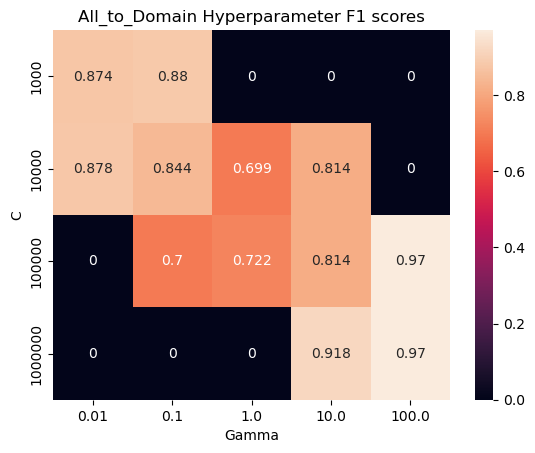

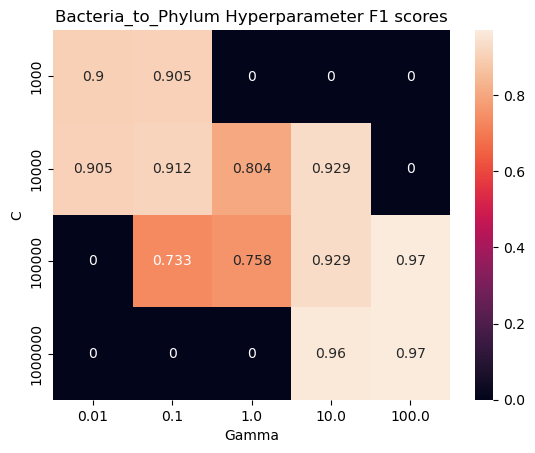

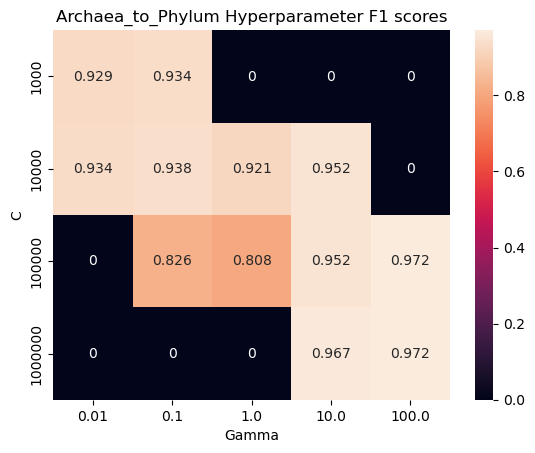

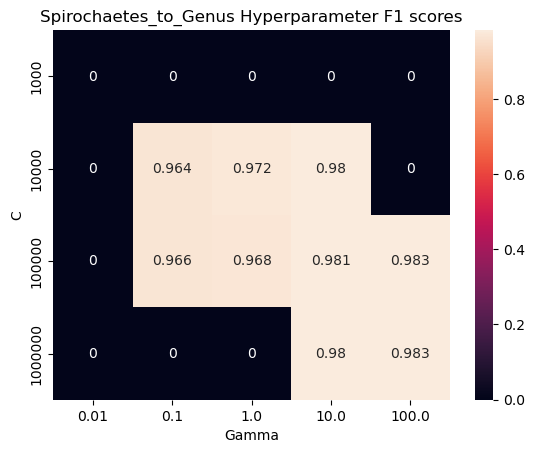

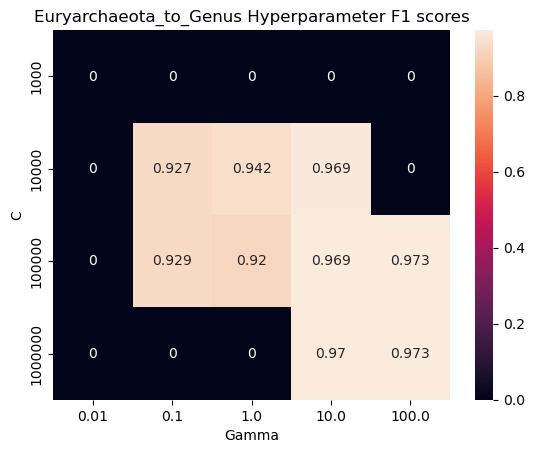

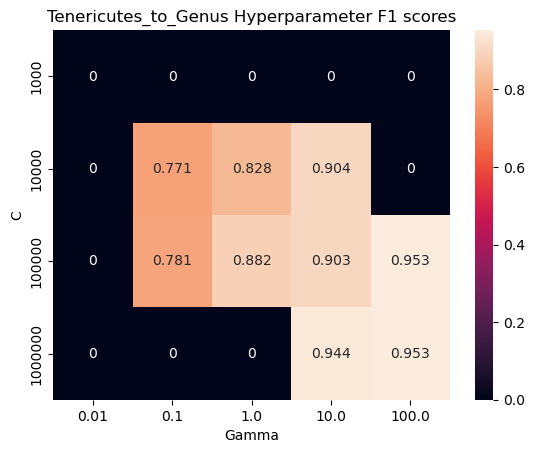

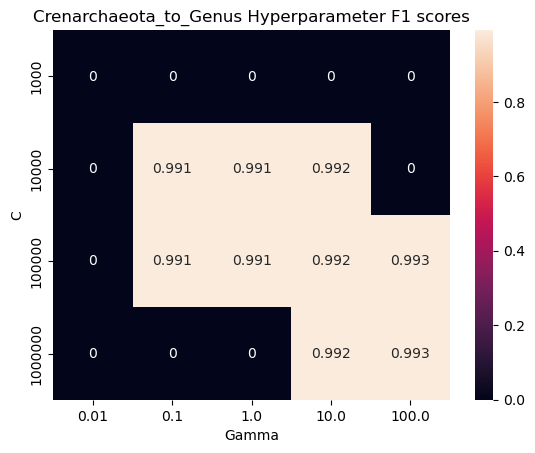

In [21]:

for i in range(len(classifiers)):
    results_df=pd.DataFrame()
    for gamma in [0.01,0.1,1,10,100]:
        results_df[gamma]=[0.0]*4
    results_df.index=[1000,10000,100000,1000000]
    for filename in [f"hyperparameters_large/classifiers_{classifiers.at[i,'Classifier Name']}.csv",f"hyperparameters_global/classifiers_{classifiers.at[i,'Classifier Name']}.csv",f"hyperparameters_new/classifiers_{classifiers.at[i,'Classifier Name']}.csv"]:
        if os.path.exists(filename):
            #print(filename)
            df=pd.read_csv(filename,index_col=0)
            df.columns=['0']
            match=re.search(f"'mean_test_score': array\(\[(0\.[\d]+ *,[ ]+)+0\.[\d]+",df.at["cv_results",'0'].replace("\n","")).group(0)
            print()
            scores=[float(num.strip()) for num in match[match.index("[")+1:].split(",")]
            match=re.search(f"'rank_test_score': array\(\[([\d]+ *,[ ]+)+[\d]+",df.at["cv_results",'0'].replace("\n","")).group(0)

            ranks=[float(num.strip()) for num in match[match.index("[")+1:].split(",")]
            match=re.search(f"'param_C': masked_array\(data=\[([\d]+ *,[ ]+)+[\d]+",df.at["cv_results",'0'].replace("\n","")).group(0)
            C_values=[float(num.strip()) for num in match[match.index("[")+1:].split(",")]
            match=re.search(f"'param_gamma': masked_array\(data=\[((0\.)*[\d]+ *,[ ]+)+(0\.)*[\d]+",df.at["cv_results",'0'].replace("\n","")).group(0)
            gamma_values=[float(num.strip()) for num in match[match.index("[")+1:].split(",")]

            for j in range(len(scores)):
                results_df.at[C_values[j],[gamma_values[j]]]=scores[j]
    sns.heatmap(results_df,annot=True,fmt='.3g')
    plt.title(classifiers.at[i,'Classifier Name']+" Hyperparameter F1 scores")
    plt.xlabel("Gamma")
    plt.ylabel("C")
    plt.show()
            

We were able to get F1 scores above 0.97 for all but the Tenericutes classifier, so this is reasonably successful overall.  We will chose the combination which produces the best F1 score except in cases where the gain is very small (<0.05), as larger values of C and gamma are also more prone to overfitting when larger portions of the dataset are used (we will use 90% for the final models).

In [22]:
classifiers["C"]=[1000000,1000000,1000000,100000,100000,100000,10000]
classifiers["Gamma"]=[100,100,100,10,10,100,0.1]

In [23]:
classifiers["Level"]=[name.split("_")[2] for name in classifiers["Classifier Name"]]

In [24]:
def make_training_data(training_organisms):
    random.seed(10)
    master_df=pd.DataFrame()
   
    for organism_name in training_organisms:
        file=genomes.at[organism_name,"Filename"]
        temp_df=pd.read_csv(file)
        for level in ['Domain','Phylum','Genus']:
            temp_df[level]=[genomes.at[organism_name,level]]*len(temp_df)
        temp_df['Organism Name']=organism_name
     
        master_df=pd.concat([master_df,temp_df])
    master_df.reset_index(inplace=True)
    master_df.drop("index",inplace=True,axis=1)
    master_df=master_df.sample(frac=1)
    print(f"{len(master_df)} sequences are in the dataset.")

    return master_df

## Hierarchical Model Construction
Now that we have selected the appropriate hyperparameters, we can train each node in a decision tree-like model with the chosen values and a larger portion of the input dataset.  The SVMs used will also contain a probability model to predict the confidence of their classification.  Consequently, nodes can pass each datapoint to the appropriate child node, if sufficiently confident, or otherwise output their parent node's classification.

In [25]:
class TreeNode:
    def __init__(self,classifier_name,classifier):
        self.classifier_name=classifier_name
        self.classifier=classifier
        self.children=[]
            
    def predict(self,X,current_best_prediction="Unclassified",confidence_threshold=0.99):
        #classify a data point.  If classification confidence is above the confidence threshold, return this classification or pass to the appropriate
        # child TreeNode, if present.  Otherwise, return the most specific classification obtained from the parent.
        result=self.classifier.predict(X)[0]
        confidence=self.classifier.predict_proba(X)[0]
        
        if max(confidence)<confidence_threshold:
            return current_best_prediction
        else:
            if len(self.children)==0:
                return result
            else:
                for i,child in enumerate(self.children):
                    if result in child.classifier_name:
                        final_result=child.predict(X,result)
                        return final_result


class Tree:
    def __init__(self,classifier_df,test_orgs):
        self.classifiers=classifier_df
        self.unknown_orgs=test_orgs
        self.nodes=[]
        self.results=pd.DataFrame()
        self.training_indices=None
        self.testing_indices=None
        self.X=None
        self.y=None
        
    def train_test_split(self):
        #decide which data points will be used for training and testing for all member nodes
        data=make_training_data([org for org in classifiers.at[0,"Member Organisms"] if org not in self.unknown_orgs])
        self.X=data[[col for col in data.columns if col not in ["Domain","Phylum","Genus","Organism Name"]]]
        self.y=data[["Domain","Phylum","Genus","Organism Name"]]
        X_train,X_test,y_train,y_test=train_test_split(self.X,self.y,test_size=0.1,stratify=data["Genus"],random_state=64)
        
        self.train_indices=list(X_train.index)
        self.test_indices=list(X_test.index)
        print(f"The known organism dataset contains {len(self.train_indices)} training data points and {len(self.test_indices)} testing data points.")

        
    def train(self):
        #train and evaluate each SVM-containing TreeNode, or load the SVM from a file if it has already been trained
        new_nodes=0
        self.results["Classifier Name"]=""*len(classifiers)
        for col in ["Train Accuracy","Test Accuracy","Train F1","Test F1","Unseen Accuracy","Unseen F1"]:
            self.results[col]=[0.0]*len(self.results)
        for i in range(len(classifiers)):
            if len(classifiers.at[i,"Member Organisms"])>1:
                if os.path.exists(f"final_models/{classifiers.at[i,'Classifier Name']}.pickle"):
                    print(f"Reading model from file final_models/{classifiers.at[i,'Classifier Name']}.pickle")
                    with open(f"final_models/{classifiers.at[i,'Classifier Name']}.pickle",'rb') as file:
                        svc=pickle.load(file)
                else:
                    new_nodes+=1
                    print(f"Training new {classifiers.at[i,'Classifier Name']} SVM model...")
                    indices=list(myTree.y[myTree.y["Organism Name"].isin(classifiers.at[i,"Member Organisms"])].index)
                    X=self.X.loc[indices]
                    y=self.y.loc[indices]
                    X_train=X.loc[[val for val in self.train_indices if val in X.index]]
                    y_train=y[classifiers.at[i,"Level"]].loc[[val for val in self.train_indices if val in X.index]]
                    X_test=X.loc[[val for val in self.test_indices if val in X.index]]
                    y_test=y[classifiers.at[i,"Level"]].loc[[val for val in self.test_indices if val in X.index]]
                    print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)
                    svc = svm.SVC(class_weight="balanced",probability=True,C=classifiers.at[i,"C"],gamma=classifiers.at[i,"Gamma"])
                    svc=svc.fit(X_train,y_train)
                    with open(f"final_models/{classifiers.at[i,'Classifier Name']}.pickle",'wb') as file:
                        pickle.dump(svc,file)
                    self.nodes.append(TreeNode(classifiers.at[i,'Classifier Name'],svc))
                    self.results.at[i,"Train Accuracy"]=accuracy_score(y_train,svc.predict(X_train))
                    self.results.at[i,"Train F1"]=f1_score(y_train,svc.predict(X_train),average="macro")
                    self.results.at[i,"Test Accuracy"]=accuracy_score(y_test,svc.predict(X_test))
                    self.results.at[i,"Test F1"]=f1_score(y_test,svc.predict(X_test),average="macro")
                    self.results.at[i,"Classifier Name"]=classifiers.at[i,"Classifier Name"]

            self.nodes.append(TreeNode(classifiers.at[i,'Classifier Name'],svc))
            if os.path.exists("Tree_results.csv") and new_nodes==0:
                self.results=pd.read_csv("Tree_results.csv",index_col=0)

    
    def predict(self,data,confidence_threshold=0.99):
        #output a classification for a set of data points using the hierarchical model and a specified confidence threshold
        results=[]
        for i in range(len(data)):
            temp=pd.DataFrame(columns=data.columns)
            temp=temp.append(data.loc[i],ignore_index=True)
            result=self.nodes[0].predict(temp,"Unclassified",confidence_threshold)
            results.append(result)
            if len(results)%10000==0:
                print(f"{len(results)} points classified so far...")
        return results
    
    def unknown_test(self,unknown_data):
        #calculate accuracy and F1 scores, then plot confusion matrices for an unknown organism dataset
        predictions=[]
        probabilities=[]
        correct_predictions=[]
        for i in range(len(self.nodes)):
            print(f"Testing classifier {classifiers.at[i,'Classifier Name']} on unknown organism dataset...")
            level=self.classifiers.at[i,"Classifier Name"].split("_")[-1]
            classes=self.classifiers.at[i,"Classes to Learn"]

            to_predict=unknown_data.loc[unknown_data[level].isin(classes)]
            X=to_predict[to_predict.columns[:256]]
            y=to_predict[level]
            prediction=self.nodes[i].classifier.predict(X)
            predictions.append(prediction)
            correct_predictions.append(y)
            temp_probabilities=myTree.nodes[i].classifier.predict_proba(X)
            proba_df=pd.DataFrame()
            proba_df["Probability"]=[max(val) for val in temp_probabilities]
            proba_df[" "]=[str(val1==val2) for val1,val2 in zip(list(prediction),list(y))]
            proba_df.loc[proba_df[" "]=="True"," "]="Correct"
            proba_df.loc[proba_df[" "]=="False"," "]="Incorrect"
            #print(proba_df)
            probabilities.append(proba_df)
            self.results.at[i,"Unseen Accuracy"]=accuracy_score(prediction,y)
            self.results.at[i,"Unseen F1"]=f1_score(prediction,y,average="macro")
            print(f'Accuracy: {self.results.at[i,"Unseen Accuracy"]}.  F1 score: {self.results.at[i,"Unseen F1"]}.')
    
        fig,ax=plt.subplots(2,4,figsize=(12,8))
        for i,df in enumerate(probabilities):
            
            sns.violinplot(ax=ax[int(i/4),i%4],x=" ",y="Probability",data=df,color="gray")
            ax[int(i/4),i%4].set_title(self.nodes[i].classifier_name)
        plt.show()
        fig,ax=plt.subplots(2,4,figsize=(25,10))
        for i,(prediction, correct_prediction) in enumerate(zip(predictions,correct_predictions)):
            #cm = confusion_matrix(correct_prediction, prediction)
            disp = ConfusionMatrixDisplay.from_predictions(correct_prediction,prediction,normalize='true',cmap="Blues",colorbar=False,ax=ax[int(i/4),i%4])
            disp.ax_.set_title(self.nodes[i].classifier_name)
            disp.plot()
            #plt.title(self.nodes[i].classifier_name)
            #plt.show()
        
    def plot_predictions(self,predictions):
        #plot a breakdown of unknown organism classifications by taxonomic level
        to_plot_df=pd.DataFrame(columns=list(classifiers["Level"].unique()))
        lower_levels=dict()
        for i in list(classifiers.index):
            group=classifiers.at[i,"Classifier Name"].split("_")[0]
            lower_levels[group]=classifiers.at[i,"Classes to Learn"]
        for key1,value1 in lower_levels.items():
            for key2,value2 in lower_levels.items():
                if key2 in value1:
                    lower_levels[key1]=lower_levels[key1]+[val for val in value2]
        #levels=["Domain","Phylum","Genus"]
        for i,level in enumerate(to_plot_df.columns):#for each, plot correctly classified, incorrectly classified, unclassified, classified correctly at higher level
            to_plot=[]
            for j,result in enumerate(predictions):
                if unknown_data.at[j,level] in lower_levels.keys():
                    lower_results=lower_levels[unknown_data.at[j,level]]
                else:
                    lower_results=[]
                #print(result,unknown_data.at[j,level])
                if result=="Unclassified":
                    to_plot+=["Unclassified"]

                elif result==unknown_data.at[j,level] or result in lower_results:
                    to_plot+=["Correct"]
                elif i>0 and "Correct" in list(to_plot_df.loc[j]):
                    if result in lower_levels.keys() and unknown_data.at[j,level] in lower_levels[result]:
                        to_plot+=["Correct at Higher Level"]
                    else:
                        to_plot+=["Incorrect"]
                else:
                    to_plot+=["Incorrect"]
            to_plot_df[level]=to_plot
        counts=pd.DataFrame(columns=to_plot_df.columns)
        for column in counts.columns:
            temp=[]
            for to_count in ["Unclassified","Correct at Higher Level","Correct","Incorrect"]:
                temp.append(sum([val==to_count for val in to_plot_df[column]]))
            counts[column]=temp
        counts.index=["Unclassified","Correct at Higher Level","Correct","Incorrect"]
        counts=counts.transpose() 
        counts=counts/sum(list(counts.loc[counts.index[0]]))
        print(counts)
        counts.to_csv("unknown_organism_breakdown.csv")
        counts.plot.bar(stacked=True,color={"Unclassified":"black","Correct at Higher Level":"olive","Correct":"green","Incorrect":"red"},figsize=(8,5))
        plt.title("Hierarchical Classifier Unknown Organism Classification Accuracy by Level")
        plt.show()
        
    def set_children(self):
        for i in range(len(self.classifiers)):
            for lower_class in classifiers.at[i,'Classes to Learn']:
                for j in range(len(self.classifiers)):
                    if lower_class in classifiers.at[j,'Classifier Name']:
                        self.nodes[i].children.append(self.nodes[j])

In [26]:
myTree=Tree(classifiers,[])
myTree.train_test_split()
myTree.train()
#myTree.results.to_csv("Tree_results.csv")

205367 sequences are in the dataset.
The known organism dataset contains 184830 training data points and 20537 testing data points.
Reading model from file final_models/All_to_Domain.pickle
Reading model from file final_models/Bacteria_to_Phylum.pickle
Reading model from file final_models/Archaea_to_Phylum.pickle
Reading model from file final_models/Spirochaetes_to_Genus.pickle
Reading model from file final_models/Euryarchaeota_to_Genus.pickle
Reading model from file final_models/Tenericutes_to_Genus.pickle
Reading model from file final_models/Crenarchaeota_to_Genus.pickle


## Training and Testing dataset results

In [27]:
myTree.results[myTree.results.columns[:-2]]

,Classifier Name,Train Accuracy,Test Accuracy,Train F1,Test F1
6,Crenarchaeota_to_Genus,0.993612,0.992231,0.993611,0.992230
5,Tenericutes_to_Genus,1.000000,0.957688,1.000000,0.922924
4,Euryarchaeota_to_Genus,1.000000,0.978701,1.000000,0.975057
3,Spirochaetes_to_Genus,1.000000,0.987359,1.000000,0.981701
2,Archaea_to_Phylum,1.000000,0.977252,1.000000,0.973952
1,Bacteria_to_Phylum,1.000000,0.974352,1.000000,0.969220
0,All_to_Domain,1.000000,0.973927,1.000000,0.973828


## Performance on Unknown Organisms
We've observed good F1 and accuracy scores on training and testing datapoints from the organisms used during training.  Let's download some new genomes and see whether the models are able to extend their performance to organisms which they have not seen before.

In [28]:
unknown_genomes=pd.DataFrame()
unknown_genomes["Organism Name"]=['Leptospira kirschneri','Leptospira santarosai','Leptospira weilii','Treponema pedis','Treponema vincentii',
                             'Treponema primitia','Borrelia parkeri','Borrelia anserina','Borrelia miyamotoi','Methanococcus voltae',
                             'Methanosarcina siciliae','Methanosarcina thermophila','Methanosarcina horonobensis','Pyrococcus yayanosii',
                             'Pyrococcus kukulkanii','Mycoplasma leachii','Mycoplasma yeatsii','Mycoplasma putrefaciens','Ureaplasma diversum',
                             'Ureaplasma canigenitalium','Ureaplasma miroungigenitalium','Pyrobaculum oguniense','Pyrobaculum neutrophilum',
                             'Pyrobaculum ferrireducens','Sulfolobus islandicus']
unknown_genomes['Genus']=[val.split(" ")[0] for val in unknown_genomes["Organism Name"]]


    
unknown_genomes["Phylum"]=[""]*len(unknown_genomes)
unknown_genomes["Domain"]=[""]*len(unknown_genomes)
for i in range(len(unknown_genomes)):
    for j in genomes.index:
        #print(unknown_genomes.at[i,"Genus"])
        #print(genomes.at[j,"Genus"])
        
        if unknown_genomes.at[i,"Genus"]==genomes.at[j,"Genus"]:
            unknown_genomes.at[i,"Domain"]=genomes.at[j,"Domain"]
            unknown_genomes.at[i,"Phylum"]=genomes.at[j,"Phylum"]
            break

unknown_genomes["Filename"]=[f"unknown_frequencies/{organism.replace(' ','_').replace('/','someannoyingslash')}_freqs.csv" for organism in unknown_genomes["Organism Name"]]

In [29]:
if not os.path.isdir("unknown_genomes"):
    os.mkdir("unknown_genomes")

for i,organism in enumerate(unknown_genomes["Organism Name"]):
    if not os.path.exists(f"unknown_genomes/{organism.replace(' ','_')}.fna"):#downloading genome should be a one-time cost
        subprocess.call(["datasets","download","genome","taxon",f"'{organism}'","--assembly-source","Genbank"], stderr=subprocess.DEVNULL, stdout=subprocess.DEVNULL)
        subprocess.call(["unzip","-o","ncbi_dataset.zip"], stderr=subprocess.DEVNULL, stdout=subprocess.DEVNULL)
        temp=os.listdir("/home/jupyter/ncbi_dataset/data/")
        genome_name=None
        for file in temp:
            if "GCA" in file:
                genome_name=file
                break
        if genome_name is not None:
            file_name=os.listdir(f"/home/jupyter/ncbi_dataset/data/{genome_name}")[0]
            subprocess.call(["mv",f"/home/jupyter/ncbi_dataset/data/{genome_name}/{file_name}",f"unknown_genomes/{organism.replace(' ','_').replace('/','someannoyingslash')}.fna"])#mv will get confused by slashes in name since it indicates a directory, so replace with something that isn't likely to otherwise be found in names
        else:
            print(f"Something went wrong downloading genome for {organism}.")#indicate any genomes that you will need to download manually
        subprocess.call(["rm","-rf","/home/jupyter/ncbi_dataset"])

In [30]:

if not os.path.isdir("unknown_frequencies"):
    os.mkdir("unknown_frequencies")

for i,organism in enumerate(unknown_genomes["Organism Name"]):
    if i%100==0 and i!=0:
        print(f"{i} organism frequencies calculated.")
    file=f"unknown_genomes/{organism.replace(' ','_').replace('/','someannoyingslash')}.fna"

    if os.path.exists(file):
        f=open(file)
        for line in f:
            unknown_genomes.at[i,"Accession"]=line.split(" ")[0][1:]
            break
        f.close()
        sequence="".join([line.strip() for line in open(file).readlines() if not line.startswith(">")])#readlines() is often bad practice for large files, but since here we know that bacterial genomes are all fairly small, so we will use the list comprehension for speed
        unknown_genomes.at[i,"Genome Size (Mb)"]=len(sequence)/1000000
        unknown_genomes.at[i,"G+C Content"]=sum([char=="C" or char=="G" for char in sequence])/len(sequence)*100
        
        if not os.path.exists(unknown_genomes.at[i,"Filename"]):

            file=f"unknown_genomes/{organism.replace(' ','_').replace('/','someannoyingslash')}.fna"

            #sequence="".join([line.strip() for line in open(file).readlines() if not line.startswith(">")])#readlines() is often bad practice for large files, but since here we know that bacterial genomes are all fairly small, so we will use the list comprehension for speed
            frequencies=[]
            for start in range(0,len(sequence),500):
                if start+500<len(sequence):
                    region=sequence[start:start+500]
                    frequencies.append([])
                    for tetranucleotide in tetranucleotides:
                        frequencies[-1].append(region.count(tetranucleotide)/497)
            df=pd.DataFrame(frequencies)
            df.columns=tetranucleotides
            df.to_csv(unknown_genomes.at[i,"Filename"],index=False)
    else:
        print(f"Could not find genome for {organism}.")

In [31]:
unknown_genomes.to_csv("unknown_genomes.csv",index=False)

In [32]:
def make_testing_data(testing_df):
    master_df=pd.DataFrame()
   
    for i in range(len(testing_df)):
        file=testing_df.at[i,"Filename"]
        temp_df=pd.read_csv(file)
        for level in ['Domain','Phylum','Genus','Organism Name']:
            temp_df[level]=[testing_df.at[i,level]]*len(temp_df)
     
        master_df=pd.concat([master_df,temp_df])
    master_df.reset_index(inplace=True)
    master_df.drop("index",inplace=True,axis=1)
    print(f"{len(master_df)} sequences are in the dataset.")
    return master_df

In [33]:
unknown_data=make_testing_data(unknown_genomes)

117398 sequences are in the dataset.


Testing classifier All_to_Domain on unknown organism dataset...
Accuracy: 0.8962077718530128.  F1 score: 0.8961975146708756.
Testing classifier Bacteria_to_Phylum on unknown organism dataset...
Accuracy: 0.9723644308214041.  F1 score: 0.9517952041266625.
Testing classifier Archaea_to_Phylum on unknown organism dataset...
Accuracy: 0.9604915810502284.  F1 score: 0.9562357623067993.
Testing classifier Spirochaetes_to_Genus on unknown organism dataset...
Accuracy: 0.9295288102805029.  F1 score: 0.932329260678872.
Testing classifier Euryarchaeota_to_Genus on unknown organism dataset...
Accuracy: 0.9473979933110368.  F1 score: 0.9216686167999084.
Testing classifier Tenericutes_to_Genus on unknown organism dataset...
Accuracy: 0.6051522248243559.  F1 score: 0.5308615552679784.
Testing classifier Crenarchaeota_to_Genus on unknown organism dataset...
Accuracy: 0.9919738883835412.  F1 score: 0.990193597248578.


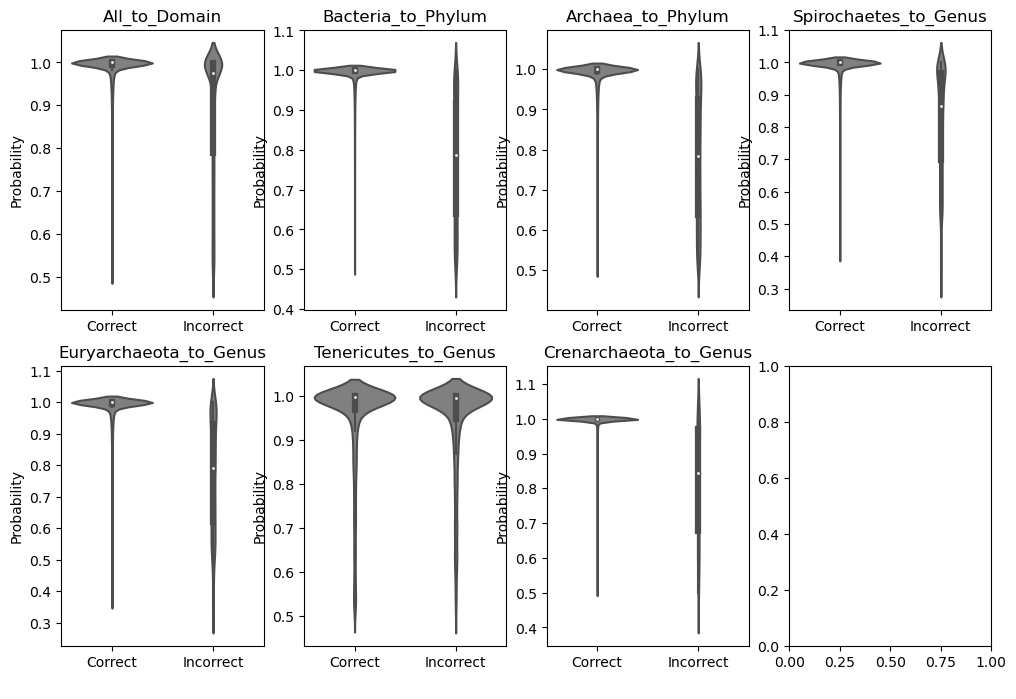

,Classifier Name,Train Accuracy,Test Accuracy,Train F1,Test F1,Unseen Accuracy,Unseen F1
6,Crenarchaeota_to_Genus,0.993612,0.992231,0.993611,0.992230,0.991974,0.990194
5,Tenericutes_to_Genus,1.000000,0.957688,1.000000,0.922924,0.605152,0.530862
4,Euryarchaeota_to_Genus,1.000000,0.978701,1.000000,0.975057,0.947398,0.921669
3,Spirochaetes_to_Genus,1.000000,0.987359,1.000000,0.981701,0.929529,0.932329
2,Archaea_to_Phylum,1.000000,0.977252,1.000000,0.973952,0.960492,0.956236
1,Bacteria_to_Phylum,1.000000,0.974352,1.000000,0.969220,0.972364,0.951795
0,All_to_Domain,1.000000,0.973927,1.000000,0.973828,0.896208,0.896198


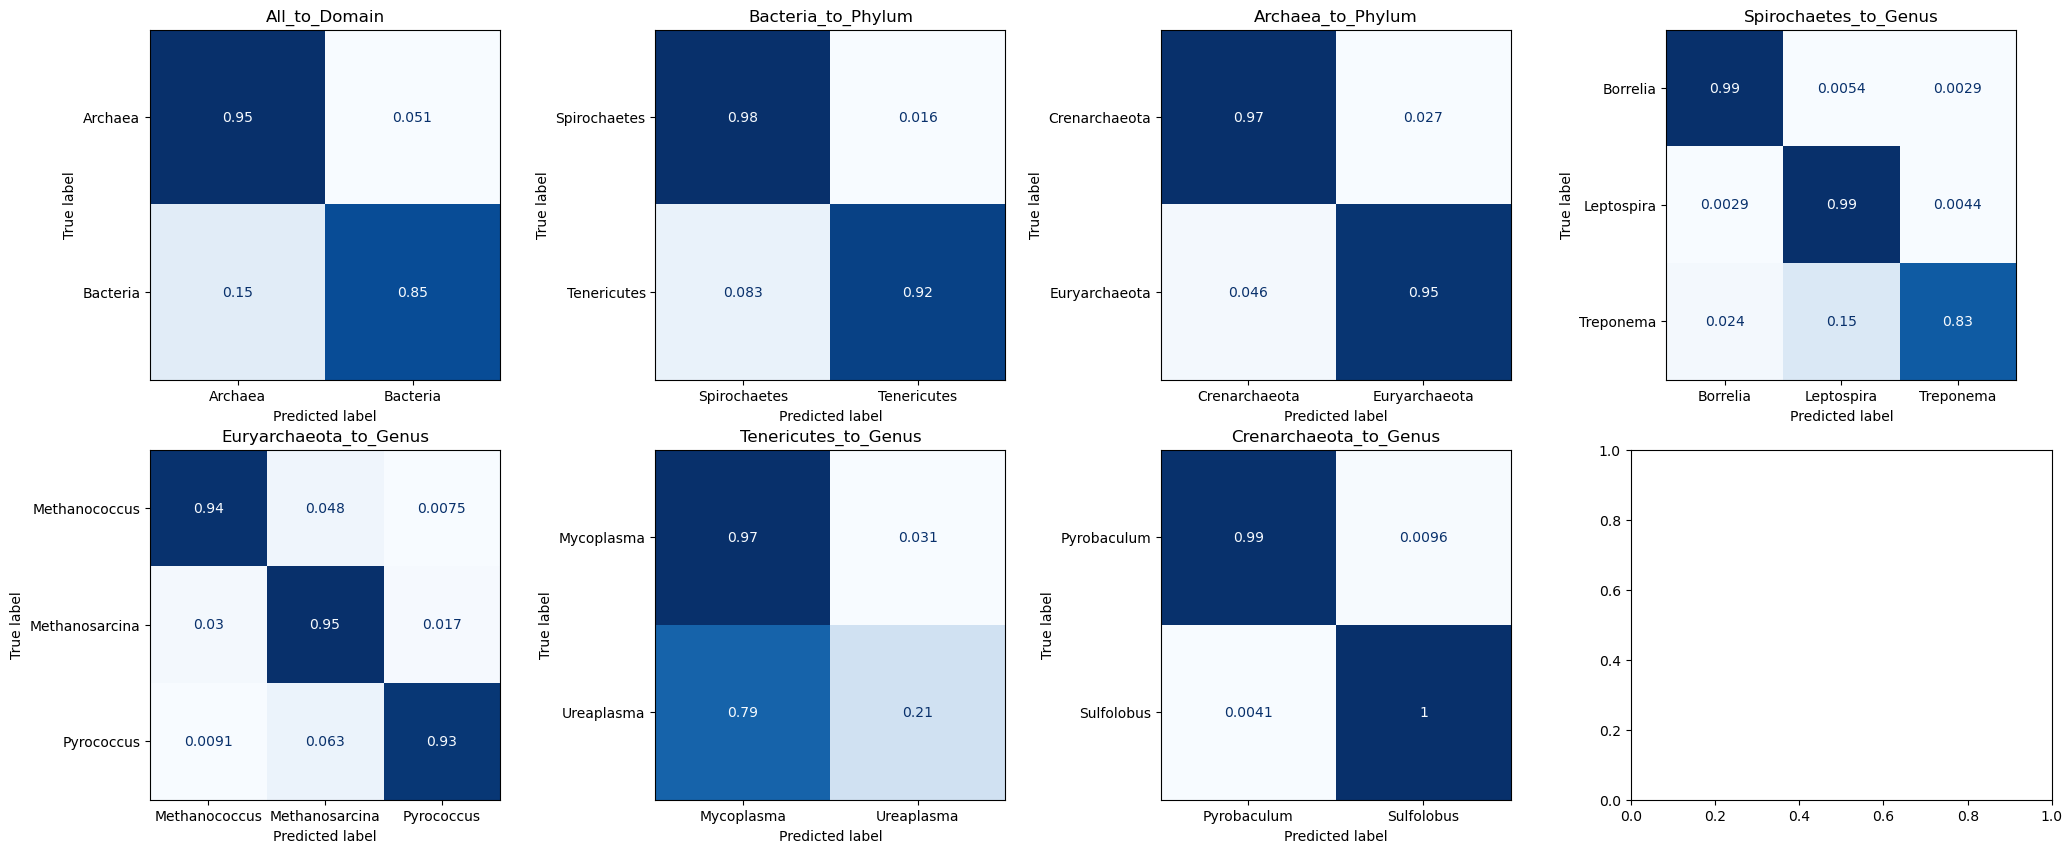

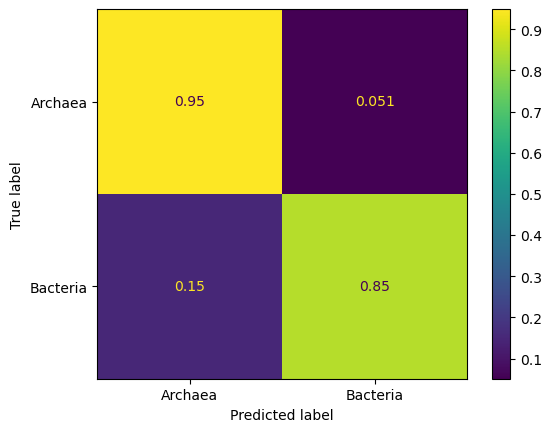

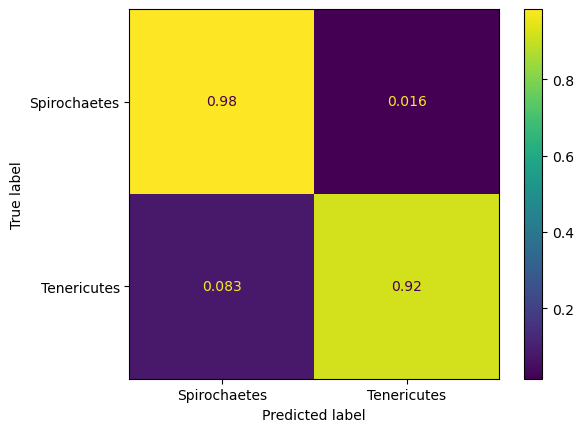

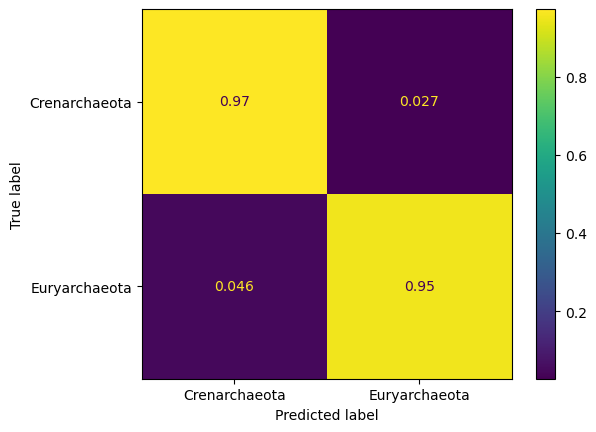

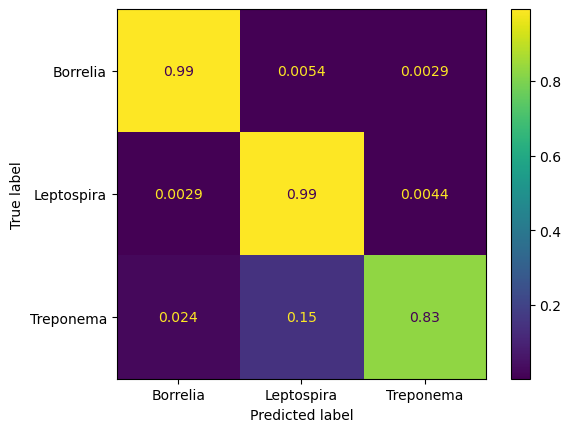

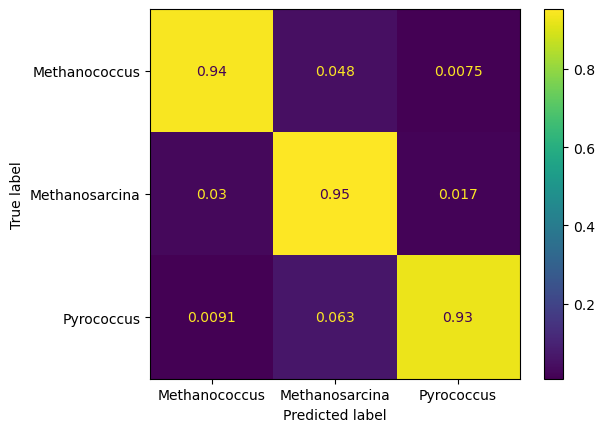

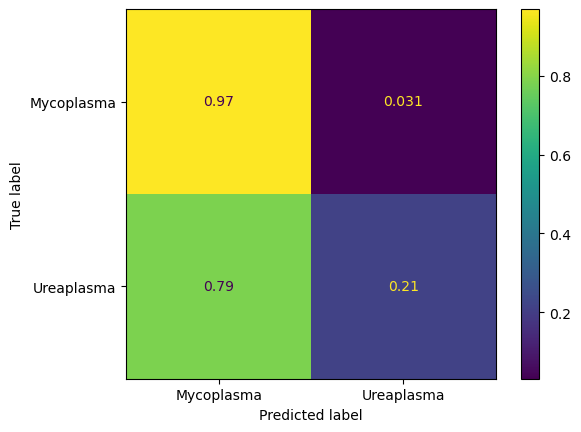

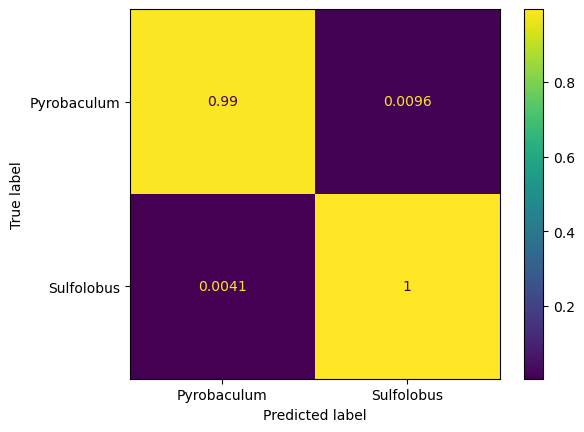

In [34]:
myTree.unknown_test(unknown_data)
myTree.results

In [51]:
myTree.set_children()
print([len(node.children) for node in myTree.nodes])
if not os.path.exists("unknown_predictions.csv"):
    predictions=myTree.predict(unknown_data[unknown_data.columns[:256]])
    file=open("unknown_predictions.csv","w")
    for entry in predictions:
        file.write(entry+",")
    file.close()
else:
    file=open("unknown_predictions.csv","r")
    predictions=file.readlines()[0].split(",")[:-1]
    file.close()

[2, 2, 2, 0, 0, 0, 0]


        Unclassified  Correct at Higher Level   Correct  Incorrect
Domain      0.256716                 0.000000  0.697414   0.045870
Phylum      0.256716                 0.091322  0.605087   0.046875
Genus       0.256716                 0.153273  0.535248   0.054762


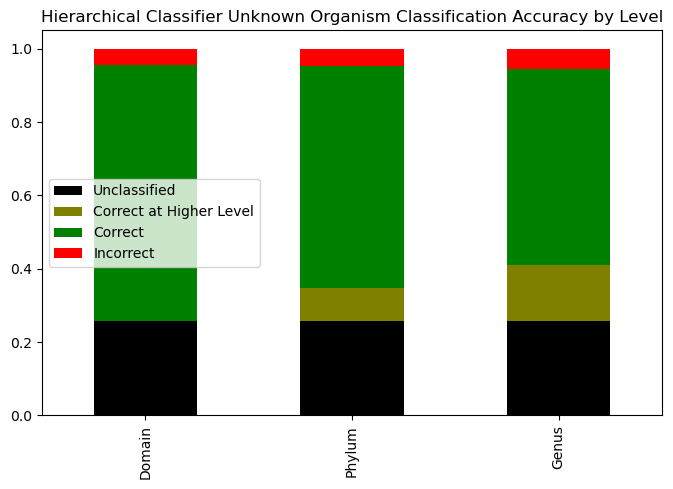

In [52]:
myTree.plot_predictions(predictions)

In [53]:
file=open("correct_unknown_classifications.csv","w")
for data in unknown_data["Genus"]:
    file.write(data+",")
file.close()

## References
1) Perry, S. C., & Beiko, R. G. (2010). Distinguishing microbial genome fragments based on their composition: evolutionary and comparative genomic perspectives. Genome biology and evolution, 2, 117–131. https://doi.org/10.1093/gbe/evq004
2) RBF SVM parameters. (n.d.). Scikit-learn. https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html